## Pivoted document length normalization
It is seen that in *many* cases normalizing the tfidf weights for each terms tends to favor weight of terms of the documents with shorter length. Pivoted document length normalization scheme brings a pivoting scheme on the table which can be used to counter the effect of this bias for short documents by making tfidf independent of the document length.

This is achieved by *tilting* the normalization curve along the pivot point defined by user with some slope. Roughly following the equation -  
`pivoted_norm = (1 - slope) * pivot + slope * old_norm`

This scheme is proposed in the paper [pivoted document length normalization](http://singhal.info/pivoted-dln.pdf)

Overall this approach can in many cases help increase the accuracy of the model where the document lengths are hugely varying in the enitre corpus.

In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression

from gensim.corpora import Dictionary
from gensim.sklearn_api.tfidf import TfIdfTransformer
from gensim.matutils import corpus2csc

import numpy as np
import matplotlib.pyplot as py

import gensim.downloader as api

In [2]:
# This function returns the model accuracy and indivitual document prob values using
# gensim's TfIdfTransformer and sklearn's LogisticRegression
def get_tfidf_scores(kwargs):
    tfidf_transformer = TfIdfTransformer(**kwargs).fit(train_corpus)

    X_train_tfidf = corpus2csc(tfidf_transformer.transform(train_corpus), num_terms=len(id2word)).T
    X_test_tfidf = corpus2csc(tfidf_transformer.transform(test_corpus), num_terms=len(id2word)).T

    clf = LogisticRegression().fit(X_train_tfidf, y_train)

    model_accuracy = clf.score(X_test_tfidf, y_test)
    doc_scores = clf.decision_function(X_test_tfidf)

    return model_accuracy, doc_scores

In [3]:
# Sort the document scores by their scores and return a sorted list
# of document score and corresponding document lengths.
def sort_length_by_score(doc_scores, X_test):
    doc_scores = sorted(enumerate(doc_scores), key=lambda x: x[1])
    doc_leng = np.empty(len(doc_scores))

    ds = np.empty(len(doc_scores))

    for i, _ in enumerate(doc_scores):
        doc_leng[i] = len(X_test[_[0]])
        ds[i] = _[1]

    return ds, doc_leng

In [4]:
nws = api.load("20-newsgroups")

In [5]:
cat1, cat2 = ('sci.electronics', 'sci.space')

In [6]:
X_train = []
X_test = []
y_train = []
y_test = []

# TODO: better way?
for i in nws:
    if i["set"] == "train" and i["topic"] == cat1:
        X_train.append(i["data"])
        y_train.append(0)
    elif i["set"] == "train" and i["topic"] == cat2:
        X_train.append(i["data"])
        y_train.append(1)
    elif i["set"] == "test" and i["topic"] == cat1:
        X_test.append(i["data"])
        y_test.append(0)
    elif i["set"] == "test" and i["topic"] == cat2:
        X_test.append(i["data"])
        y_test.append(1)

In [7]:
id2word = Dictionary([_.split() for _ in X_train])

train_corpus = [id2word.doc2bow(i.split()) for i in X_train]
test_corpus = [id2word.doc2bow(i.split()) for i in X_test]

In [8]:
print(len(X_train), len(X_test))

(1184, 787)


In [9]:
# We perform our analysis on top k documents which is almost top 10% most scored documents
k = len(X_test) / 10

### Get TFIDF scores for corpus without pivoted document length normalisation

In [10]:
params = {}
model_accuracy, doc_scores = get_tfidf_scores(params)
print(model_accuracy)

0.9440914866581956


In [11]:
print ("Normal cosine normalisation favors short documents as our top {}\
    docs have a smaller mean doc length of {} compared to the corpus mean doc length of {}"
    .format(k, sort_length_by_score(doc_scores, X_test)[1][:k].mean(),
    sort_length_by_score(doc_scores, X_test)[1].mean()))

Normal cosine normalisation favors short documents as our top 78    docs have a smaller mean doc length of 1290.07692308 compared to the corpus mean doc length of 1577.79923761


### Get TFIDF scores for corpus with pivoted document length normalisation testing on various values of alpha.

In [12]:
best_model_accuracy = 0
optimum_slope = 0
for slope in np.arange(0, 1.1, 0.1):
    params = {"pivot": 100, "slope": slope}

    model_accuracy, doc_scores = get_tfidf_scores(params)

    if model_accuracy > best_model_accuracy:
        best_model_accuracy = model_accuracy
        optimum_slope = slope

    print ("Score for slope {} is {}".format(slope, model_accuracy))

print ("We get best score of {} at slope {}".format(best_model_accuracy, optimum_slope))

Score for slope 0.0 is 0.921219822109
Score for slope 0.1 is 0.92249047014
Score for slope 0.2 is 0.925031766201
Score for slope 0.3 is 0.926302414231
Score for slope 0.4 is 0.931385006353
Score for slope 0.5 is 0.937738246506
Score for slope 0.6 is 0.939008894536
Score for slope 0.7 is 0.944091486658
Score for slope 0.8 is 0.942820838628
Score for slope 0.9 is 0.945362134689
Score for slope 1.0 is 0.944091486658
We get best score of 0.945362134689 at slope 0.9


In [13]:
params = {"pivot": 100, "slope": optimum_slope}
model_accuracy, doc_scores = get_tfidf_scores(params)
print (model_accuracy)

0.9453621346886912


In [14]:
print ("With pivoted normalisation top {} docs have mean length of {}\
   which is much closer to the corpus mean doc length of {}"
   .format(k, sort_length_by_score(doc_scores, X_test)[1][:k].mean(),
   sort_length_by_score(doc_scores, X_test)[1].mean()))

With pivoted normalisation top 78 docs have mean length of 1432.05128205   which is much closer to the corpus mean doc length of 1577.79923761


## Visualizing the pivoted normalization

Since cosine normalization favors retrieval of short documents from the plot we can see that when slope was 1 (when pivoted normalisation was not applied) short documents with length of around 500 had very good score hence the bias for short documents can be seen. As we varied the value of slope from 1 to 0 we introdcued a new bias for long documents to counter the bias caused by cosine normalisation. Therefore at a certain point we got an optimum value of slope which is 0.5 where the overall accuracy of the model is increased.


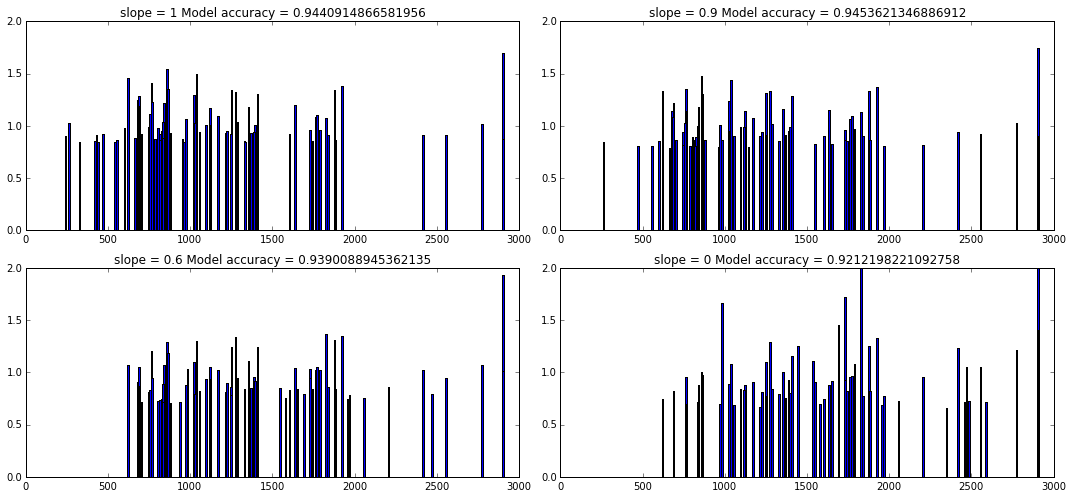

In [15]:
best_model_accuracy = 0
optimum_slope = 0
optimum_pivot = 0
w = 2
h = 2
f, axarr = py.subplots(h, w, figsize=(15, 7))

it = 0
for slope in [1, 0.9, 0.6, 0]:
    params = {"pivot": 100, "slope": slope}

    model_accuracy, doc_scores = get_tfidf_scores(params)

    if model_accuracy > best_model_accuracy:
        best_model_accuracy = model_accuracy
        optimum_slope = slope

    doc_scores, doc_leng = sort_length_by_score(doc_scores, X_test)

    y = abs(doc_scores[:k, np.newaxis])
    x = doc_leng[:k, np.newaxis]
    py.title(slope)

    axarr[it / w, it % w].bar(x, y, width=10)
    axarr[it / w, it % w].set_title("slope = " + str(slope) + " Model accuracy = " + str(model_accuracy))
    axarr[it / w, it % w].set_ylim([0, 2])
    axarr[it / w, it % w].set_xlim([0, 3000])
    it += 1

py.tight_layout()
py.show()

The above histogram plot helps us visualize the effect of `slope`. For top k documents we have document length on the x axis and their respective scores of belonging to a specific class on y axis.  
As we decrease the slope the density of bins is shifted from low document length (around ~250-500) to over ~750 document length. This suggests that the positive biasness which was seen at `slope=1` (or when regular tfidf was used) for short documents is now reduced.  
But as we continue to decrease the slope to very small values the model accuracy again decreases since now we have introduced a positive biasness for long documents which is again undesirable. So we get the optimum slope or the max model accuracy when slope is 0.9.